<a href="https://colab.research.google.com/github/pooyapaydary/Python/blob/main/mini_project_10Nov25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#data set # Messy water-quality dataset generator
# Creates: wq_readings_messy.csv, wq_stations_messy.csv, wq_lab_results_messy.csv

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(7)
random.seed(7)

# ---------- helpers ----------
def random_date(start, end):
    delta = end - start
    int_delta = int(delta.total_seconds())
    return start + timedelta(seconds=random.randint(0, int_delta))

def inject_typos(value, variants):
    return random.choice(variants) if random.random() < 0.1 else value

# ---------- stations.csv ----------
stations = [
    {"station_id": "ST-001", "name": "Devens River East", "lat": 42.545, "lon": -71.611, "river": "Nashua", "installed_date":"2021-03-15", "is_active":"Y", "region":"Central", "town":"Devens"},
    {"station_id": "ST-002", "name": "Ayer Marsh", "lat": 42.559, "lon": -71.588, "river": "Nashua", "installed_date":"2022/06/01", "is_active":"Yes", "region":"Central", "town":"Ayer"},
    {"station_id": "ST-003", "name": "Groton Bend", "lat": 42.611, "lon": -71.574, "river": "Nashua", "installed_date":"15-07-2023", "is_active":"N", "region":"North", "town":"Groton"},
    {"station_id": "ST-004", "name": "Leominster Brook", "lat": 42.525, "lon": -71.761, "river": "Monoosnoc", "installed_date":"2020-11-05", "is_active":"No", "region":"West", "town":"Leominster "},  # trailing space
    {"station_id": "ST-005", "name": "Fitchburg West", "lat": 42.581, "lon": -71.812, "river": "North Nashua", "installed_date":"2019-02-28", "is_active":"TRUE", "region":"West", "town":"Fitchburg"},
    {"station_id": "ST-006", "name": "Lancaster Dam", "lat": 42.455, "lon": -71.681, "river": "Nashua", "installed_date":"2018-09-10", "is_active":"False", "region":"South", "town":"Lancaster"},
]
df_stations = pd.DataFrame(stations)

# Inject a duplicate + missing/variant values
df_stations = pd.concat([df_stations, df_stations.iloc[[2]]], ignore_index=True)
df_stations.loc[1, "lat"] = np.nan
df_stations.loc[4, "river"] = None
df_stations.loc[5, "region"] = "west"  # lowercase variant

# ---------- readings.csv ----------
start_dt = datetime(2025, 8, 1)
end_dt = datetime(2025, 10, 31)

rows = []
sample_id_counter = 1000

for st in df_stations["station_id"].dropna().unique():
    n = 40 if st == "ST-003" else 60  # fewer rows for dup station to create merge quirks
    for _ in range(n):
        ts = random_date(start_dt, end_dt)
        date_formats = [
            ts.strftime("%Y-%m-%d %H:%M:%S"),
            ts.strftime("%m/%d/%Y %I:%M %p"),
            ts.strftime("%d-%b-%Y %H:%M"),
        ]
        ts_str = random.choice(date_formats)

        # temperature with mixed units and types
        temp_c = np.clip(np.random.normal(15, 6), -2, 30)
        if random.random() < 0.15:  # Fahrenheit with suffix
            temp_f = temp_c * 9/5 + 32 + np.random.normal(0, 1)
            temp_val = f"{round(temp_f,1)} °F"
        else:
            temp_val = str(round(temp_c, 1)) if random.random() < 0.15 else round(temp_c, 1)
        if random.random() < 0.02:  # absurd outliers
            temp_val = 120 if random.random() < 0.5 else "-15"

        # pH with occasional impossible/string
        pH = np.clip(np.random.normal(7.2, 0.5), 5.5, 9.5)
        if random.random() < 0.05: pH = 14.5
        if random.random() < 0.08: pH = f"{pH:.1f}"

        # other fields
        do = max(0, np.random.normal(8.0, 2.0))
        if random.random() < 0.04: do = -1  # invalid
        turb = max(0, np.random.exponential(4.0))
        cond = max(10, np.random.normal(350, 80))
        ecoli = max(0, int(np.random.lognormal(mean=3.5, sigma=0.6)))
        if random.random() < 0.06: ecoli = "<10"  # censoring-style
        rainfall = np.nan if random.random() < 0.25 else round(max(0, np.random.exponential(2.0)), 1)
        sampler = random.choice(["AP", "DL", " kp", "PP", "pp", "NA"])  # inconsistent case/space
        qc_flag = inject_typos("OK", ["ok", "Okay", "0K", "O.K."])
        if random.random() < 0.12:
            qc_flag = inject_typos("REVIEW", ["review", "Reveiw", "Rev.", "RVW"])
        comments = random.choice(["", "   ", "rain overnight", "fish smell", ""])

        rows.append({
            "station_id": st,
            "sample_id": f"S{sample_id_counter}",
            "timestamp": ts_str,
            "temp": temp_val,
            "pH": pH,
            "DO_mg_L": do,
            "turbidity_NTU": turb,
            "conductivity_uScm": cond,
            "e_coli_mpn_100ml": ecoli,
            "rainfall_mm": rainfall,
            "sampler": sampler,
            "qc_flag": qc_flag,
            "comments": comments
        })
        sample_id_counter += 1

df_readings = pd.DataFrame(rows)

# Sprinkle decimal commas in a subset
for col in ["turbidity_NTU", "conductivity_uScm"]:
    mask = np.random.rand(len(df_readings)) < 0.08
    df_readings.loc[mask, col] = df_readings.loc[mask, col].map(lambda x: f"{x:.1f}".replace(".", ","))

# ---------- lab_results.csv ----------
lab_rows = []
for sid in df_readings["sample_id"].sample(frac=0.85, random_state=7):  # some missing lab results
    nitrate = max(0, np.random.lognormal(mean=0.5, sigma=0.6))
    phosphate = max(0, np.random.lognormal(mean=0.2, sigma=0.5))
    lead = max(0, np.random.lognormal(mean=1.0, sigma=0.7)) * 2  # ug/L

    # censoring with "<"
    if random.random() < 0.2: nitrate = f"<{round(nitrate*0.3, 2)}"
    if random.random() < 0.2: phosphate = f"<{round(phosphate*0.3, 2)}"
    if random.random() < 0.2: lead = f"<{round(lead*0.2, 1)}"

    lab_received = random_date(datetime(2025,8,1), datetime(2025,11,5)).strftime(random.choice(["%Y-%m-%d", "%d/%m/%Y"]))
    method = inject_typos("EPA 300.1", ["EPA300.1", "ePa 300,1", "EPA 300-1", "EPA 300. 1"])
    dil = random.choice([1, 2, 5, 10])
    if random.random() < 0.12: dil = str(dil) + "x"

    lab_rows.append({
        "sample_id": sid,
        "nitrate_mg_L": nitrate,
        "phosphate_mg_L": phosphate,
        "lead_ug_L": lead,
        "lab_received": lab_received,
        "method": method,
        "dil_factor": dil
    })

df_lab = pd.DataFrame(lab_rows)

# ---------- save ----------
readings_path = "wq_readings_messy.csv"
stations_path = "wq_stations_messy.csv"
lab_path = "wq_lab_results_messy.csv"

df_readings.to_csv(readings_path, index=False)
df_stations.to_csv(stations_path, index=False)
df_lab.to_csv(lab_path, index=False)

print("Saved:")
print(readings_path)
print(stations_path)
print(lab_path)


Saved:
wq_readings_messy.csv
wq_stations_messy.csv
wq_lab_results_messy.csv


/tmp/ipython-input-4138862336.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['12,0' '1,0' '1,6' '0,6' '2,4' '2,9' '0,5' '4,8' '2,1' '5,4' '4,8' '8,2'
 '6,6' '4,9' '2,6' '2,2' '4,5' '2,7' '0,2' '0,7' '3,2' '1,2']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_readings.loc[mask, col] = df_readings.loc[mask, col].map(lambda x: f"{x:.1f}".replace(".", ","))
/tmp/ipython-input-4138862336.py:109: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['421,5' '380,8' '278,0' '336,1' '252,2' '323,7' '374,1' '361,3' '110,0'
 '434,1' '170,1' '228,4' '440,8' '291,7' '387,0' '458,1' '232,5' '322,3'
 '300,0' '483,5' '286,5' '252,2' '250,9']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_readings.loc[mask, col] = df_readings.loc[mask, col].ma

🧩 Final Deliverables

You’ll submit these as results, charts, and brief notes (no need for fancy dashboard).

1. Data Integrity Report

How many unique stations and unique samples exist after cleaning?

How many rows were dropped or corrected (duplicates, missing critical data, etc.)?

Which columns required unit or type conversion?

Summarize QC flags (% OK vs REVIEW).

2. Environmental Summary

Average temperature (°C), pH, DO, and turbidity by station and by month.

Flag any stations that show abnormal readings (e.g., DO < 2 mg/L or pH outside 6–9).

For each variable, report mean, std, min, max, count of missing.

3. Microbial Water Quality

Find samples where E. coli exceeds 235 MPN/100 mL (EPA recreational limit).

Which stations exceed that limit most often?

If rainfall data are available, plot E. coli vs rainfall (scatter or regression trend).

4. Nutrient & Heavy-Metal Lab Results

Merge the lab data and compute mean/median for nitrate, phosphate, and lead (mg L⁻¹ or µg L⁻¹).

Identify any censored values (“<x”) and decide how you’ll represent them numerically.

Which samples have the highest lead concentrations? List top 5 with station & date.

5. Temporal Trends

Plot time-series for one or two parameters (e.g., temperature, DO, nitrate) for each station.

Add monthly averages to visualize seasonal shifts (Aug–Oct).

Highlight any station-month where values are far from the network mean.

6. Correlation Insights

Compute and visualize a correlation matrix among numeric parameters (temp, DO, turbidity, conductivity, nutrients, etc.).

Which pair of variables has the strongest negative and positive correlations?

Optional: a pairplot or heatmap (Seaborn).

7. Storytelling Insight

Write a short 1-paragraph summary:

“Based on data from August–October 2025, which part of the watershed shows the poorest water quality and why?”

🕓 Estimated time:

Cleaning & merging: 2.5 – 3 hours

EDA + visuals: 1.5 hours

Summary report: 30 minutes
≈ ~5 hours total at your current 45-hour skill level — a solid weekend or two study sessions.

In [2]:
#Reading the files
from google.colab import files
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import datetime

df_lab=pd.read_csv("wq_lab_results_messy.csv")
df_wq=pd.read_csv("wq_readings_messy.csv")
df_lab=pd.read_csv("wq_lab_results_messy.csv")
sd_stations=pd.read_csv("wq_stations_messy.csv")


In [3]:
#Exploring df_lab
print (df_lab.info())
print("\n")
print (df_lab.head(3))
print("\n")
print(df_lab.describe())
print("\n")
print(df_lab.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sample_id       289 non-null    object
 1   nitrate_mg_L    289 non-null    object
 2   phosphate_mg_L  289 non-null    object
 3   lead_ug_L       289 non-null    object
 4   lab_received    289 non-null    object
 5   method          289 non-null    object
 6   dil_factor      289 non-null    object
dtypes: object(7)
memory usage: 15.9+ KB
None


  sample_id        nitrate_mg_L      phosphate_mg_L           lead_ug_L  \
0     S1114   2.357597230659991               <0.87  2.4588956337383854   
1     S1129  1.6780045554086973  0.9662297218019004    4.15920368082352   
2     S1188   2.179917543206679  0.6705061979651321   9.181003978857335   

  lab_received     method dil_factor  
0   29/08/2025  EPA 300.1          5  
1   2025-08-07  EPA 300.1          5  
2   2025-08-14  EPA 300.1         

In [4]:
#removing "<"" and "X" in dil factor and the dataframe
df_lab=df_lab.applymap(lambda x: "0" if "<" in x else x)
df_lab["dil_factor"]=df_lab["dil_factor"].apply(lambda y: y[0] if "x" in y else y)

/tmp/ipython-input-3985615812.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_lab=df_lab.applymap(lambda x: "0" if "<" in x else x)


In [5]:
#putting sample_id as index
df_lab=df_lab.set_index("sample_id")

In [6]:

#changing all the rows to numeric
for col in df_lab.columns:
  if col not in ["method", "lab_received"]:
      df_lab[col]=df_lab[col].apply(pd.to_numeric)


In [7]:
#Changing the dates to datetime
from dateutil import parser
df_lab["lab_received"]=df_lab["lab_received"].apply(parser.parse)

In [8]:
#making methods unified
df_lab["method"]=df_lab["method"].apply(lambda x: "EPA 300.1")


In [9]:
#data frame df_lab is clean
df_lab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, S1114 to S1004
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   nitrate_mg_L    289 non-null    float64       
 1   phosphate_mg_L  289 non-null    float64       
 2   lead_ug_L       289 non-null    float64       
 3   lab_received    289 non-null    datetime64[ns]
 4   method          289 non-null    object        
 5   dil_factor      289 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 15.8+ KB


In [10]:
#Exploring water quality data frame

print (df_wq.info())
print("\n")
print (df_wq.head(3))
print("\n")
print(df_wq.describe())
print("\n")
print(df_wq.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station_id         340 non-null    object 
 1   sample_id          340 non-null    object 
 2   timestamp          340 non-null    object 
 3   temp               340 non-null    object 
 4   pH                 340 non-null    float64
 5   DO_mg_L            340 non-null    float64
 6   turbidity_NTU      340 non-null    object 
 7   conductivity_uScm  340 non-null    object 
 8   e_coli_mpn_100ml   340 non-null    object 
 9   rainfall_mm        257 non-null    float64
 10  sampler            285 non-null    object 
 11  qc_flag            340 non-null    object 
 12  comments           202 non-null    object 
dtypes: float64(3), object(10)
memory usage: 34.7+ KB
None


  station_id sample_id            timestamp     temp        pH   DO_mg_L  \
0     ST-001     S1000  2025-09-01 10:

In [11]:
#cleaning waterquality data frame
#set sample_id as index
df_wq=df_wq.set_index("sample_id")

In [12]:
#make temps uniform and "c"

for x in df_wq["temp"]:
  x=x.strip().lower()
  if "f" in x:
    x=x[0:4]
    x=float(x)
    x=x-32*5/9
  else:
    x=float(x)

In [13]:

#make all the applicable columns as numbers
for col in df_wq.columns:
  if col not in ["station_id","sampler", "qc_flag", "comments","timestamp"]:
      df_wq[col]=df_wq[col].apply(pd.to_numeric, errors="coerce")
  else:
    df_wq[col]=df_wq[col]

In [14]:
#make the time column datetime
df_wq["timestamp"]=df_wq["timestamp"].apply(parser.parse)

In [15]:
#making commnets and sampler look uniform
df_wq["sampler"]=df_wq["sampler"].str.lower().str.strip()
df_wq["comments"]=df_wq["comments"].str.lower().str.strip()

In [16]:
#df_wq is clean
df_wq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, S1000 to S1339
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   station_id         340 non-null    object        
 1   timestamp          340 non-null    datetime64[ns]
 2   temp               280 non-null    float64       
 3   pH                 340 non-null    float64       
 4   DO_mg_L            340 non-null    float64       
 5   turbidity_NTU      318 non-null    float64       
 6   conductivity_uScm  317 non-null    float64       
 7   e_coli_mpn_100ml   319 non-null    float64       
 8   rainfall_mm        257 non-null    float64       
 9   sampler            285 non-null    object        
 10  qc_flag            340 non-null    object        
 11  comments           202 non-null    object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 34.5+ KB


In [17]:


print(df_wq.head())
print("\n")
print("\n")
print("\n")

print(df_lab.head())


          station_id           timestamp  temp        pH   DO_mg_L  \
sample_id                                                            
S1000         ST-001 2025-09-01 10:35:06  25.1  6.967031  8.065640   
S1001         ST-001 2025-10-20 06:42:00   NaN  7.199336  7.046137   
S1002         ST-001 2025-08-15 00:08:00   NaN  7.158432  8.141458   
S1003         ST-001 2025-08-20 23:55:00   5.8  7.235330  5.785765   
S1004         ST-001 2025-10-10 19:43:00   1.0  7.115744  3.499331   

           turbidity_NTU  conductivity_uScm  e_coli_mpn_100ml  rainfall_mm  \
sample_id                                                                    
S1000           2.781562         382.601303              30.0          NaN   
S1001           0.272843         447.338588              44.0          0.5   
S1002                NaN         323.263983              39.0          4.8   
S1003           5.551741         319.028805             111.0          0.5   
S1004           7.278611         319.6636

In [18]:
#next is to clean df_stations and to fix for nans


In [19]:
#Exploring df_stations
print (df_stations.info())
print("\n")
print (df_stations.head(3))
print("\n")
print(df_stations.describe())
print("\n")
print(df_stations.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   station_id      7 non-null      object 
 1   name            7 non-null      object 
 2   lat             6 non-null      float64
 3   lon             7 non-null      float64
 4   river           6 non-null      object 
 5   installed_date  7 non-null      object 
 6   is_active       7 non-null      object 
 7   region          7 non-null      object 
 8   town            7 non-null      object 
dtypes: float64(2), object(7)
memory usage: 636.0+ bytes
None


  station_id               name     lat     lon   river installed_date  \
0     ST-001  Devens River East  42.545 -71.611  Nashua     2021-03-15   
1     ST-002         Ayer Marsh     NaN -71.588  Nashua     2022/06/01   
2     ST-003        Groton Bend  42.611 -71.574  Nashua     15-07-2023   

  is_active   region    town  
0         Y  

In [20]:
df_stations["installed_date"]=df_stations["installed_date"].apply(parser.parse)

In [21]:
df_stations["is_active"].unique()

array(['Y', 'Yes', 'N', 'No', 'TRUE', 'False'], dtype=object)

In [22]:
df_stations["is_active"]=df_stations["is_active"].apply(lambda x: True if x in ['Y', 'Yes', 'TRUE'] else False)

In [23]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   station_id      7 non-null      object        
 1   name            7 non-null      object        
 2   lat             6 non-null      float64       
 3   lon             7 non-null      float64       
 4   river           6 non-null      object        
 5   installed_date  7 non-null      datetime64[ns]
 6   is_active       7 non-null      bool          
 7   region          7 non-null      object        
 8   town            7 non-null      object        
dtypes: bool(1), datetime64[ns](1), float64(2), object(5)
memory usage: 587.0+ bytes


In [24]:
df_stations

,station_id,name,lat,lon,river,installed_date,is_active,region,town
0,ST-001,Devens River East,42.545,-71.611,Nashua,2021-03-15,True,Central,Devens
1,ST-002,Ayer Marsh,NaN,-71.588,Nashua,2022-06-01,True,Central,Ayer
2,ST-003,Groton Bend,42.611,-71.574,Nashua,2023-07-15,False,North,Groton
3,ST-004,Leominster Brook,42.525,-71.761,Monoosnoc,2020-11-05,False,West,Leominster
4,ST-005,Fitchburg West,42.581,-71.812,None,2019-02-28,True,West,Fitchburg
5,ST-006,Lancaster Dam,42.455,-71.681,Nashua,2018-09-10,False,west,Lancaster
6,ST-003,Groton Bend,42.611,-71.574,Nashua,2023-07-15,False,North,Groton


In [25]:
#make all the contents lower
for col in df_stations.columns:
  if col not in ["is_active", "installed_date", "lat","lon","station_id"]:
     df_stations[col]= df_stations[col].apply(lambda x: x.strip().lower() if isinstance(x, str) else x)

In [26]:
df_stations

,station_id,name,lat,lon,river,installed_date,is_active,region,town
0,ST-001,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
1,ST-002,ayer marsh,NaN,-71.588,nashua,2022-06-01,True,central,ayer
2,ST-003,groton bend,42.611,-71.574,nashua,2023-07-15,False,north,groton
3,ST-004,leominster brook,42.525,-71.761,monoosnoc,2020-11-05,False,west,leominster
4,ST-005,fitchburg west,42.581,-71.812,None,2019-02-28,True,west,fitchburg
5,ST-006,lancaster dam,42.455,-71.681,nashua,2018-09-10,False,west,lancaster
6,ST-003,groton bend,42.611,-71.574,nashua,2023-07-15,False,north,groton


In [27]:
#df_stations is clean
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   station_id      7 non-null      object        
 1   name            7 non-null      object        
 2   lat             6 non-null      float64       
 3   lon             7 non-null      float64       
 4   river           6 non-null      object        
 5   installed_date  7 non-null      datetime64[ns]
 6   is_active       7 non-null      bool          
 7   region          7 non-null      object        
 8   town            7 non-null      object        
dtypes: bool(1), datetime64[ns](1), float64(2), object(5)
memory usage: 587.0+ bytes


In [28]:
#next step is to fix Nans and start answering deliverables.

In [29]:
df_stations["river"]=df_stations["river"].fillna("unknown")

In [30]:
df_wq[df_wq["rainfall_mm"].isna()]

,station_id,timestamp,temp,pH,DO_mg_L,turbidity_NTU,conductivity_uScm,e_coli_mpn_100ml,rainfall_mm,sampler,qc_flag,comments
sample_id,,,,,,,,,,,,
S1000,ST-001,2025-09-01 10:35:06,25.1,6.967031,8.065640,2.781562,382.601303,30.0,NaN,pp,ok,NaN
S1004,ST-001,2025-10-10 19:43:00,1.0,7.115744,3.499331,7.278611,319.663642,21.0,NaN,NaN,0K,rain overnight
S1015,ST-001,2025-08-08 19:40:02,NaN,6.964037,6.271020,NaN,379.949628,15.0,NaN,NaN,OK,NaN
S1020,ST-001,2025-08-13 16:42:00,24.2,7.083282,8.594391,8.242548,429.429147,22.0,NaN,pp,OK,rain overnight
S1021,ST-001,2025-10-06 05:56:00,12.8,6.900000,8.419444,1.790029,249.730156,NaN,NaN,pp,OK,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S1314,ST-006,2025-09-29 06:48:00,7.6,6.893153,6.537158,2.926609,427.875449,52.0,NaN,dl,OK,NaN
S1315,ST-006,2025-08-14 18:56:00,NaN,8.400000,6.753633,6.010517,367.839618,62.0,NaN,ap,REVIEW,NaN
S1318,ST-006,2025-08-18 12:50:46,NaN,7.550341,9.129479,0.243669,400.822845,19.0,NaN,ap,OK,


In [31]:
#replacing Nan for rain fall with the average value of the rainfall for that month in that station
#first need to drop the ones without the date
df_wq["timestamp"]=df_wq["timestamp"].dropna()


df_wq["month"]=df_wq["timestamp"].dt.month
df_wq["temp mean"]=df_wq.groupby(["station_id","month"])["rainfall_mm"].transform( "mean")

In [32]:
df_wq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, S1000 to S1339
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   station_id         340 non-null    object        
 1   timestamp          340 non-null    datetime64[ns]
 2   temp               280 non-null    float64       
 3   pH                 340 non-null    float64       
 4   DO_mg_L            340 non-null    float64       
 5   turbidity_NTU      318 non-null    float64       
 6   conductivity_uScm  317 non-null    float64       
 7   e_coli_mpn_100ml   319 non-null    float64       
 8   rainfall_mm        257 non-null    float64       
 9   sampler            285 non-null    object        
 10  qc_flag            340 non-null    object        
 11  comments           202 non-null    object        
 12  month              340 non-null    int32         
 13  temp mean          340 non-null    float64       
dtypes: dateti

In [33]:
#replace nan and other values with average of month-station

for col in ["temp", "pH", "DO_mg_L", "turbidity_NTU", "conductivity_uScm", "e_coli_mpn_100ml","rainfall_mm"]:
    df_wq[col]=np.where(df_wq[col].isna(), df_wq.groupby(["station_id","month"])[col].transform( "mean"),df_wq[col])
df_wq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, S1000 to S1339
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   station_id         340 non-null    object        
 1   timestamp          340 non-null    datetime64[ns]
 2   temp               340 non-null    float64       
 3   pH                 340 non-null    float64       
 4   DO_mg_L            340 non-null    float64       
 5   turbidity_NTU      340 non-null    float64       
 6   conductivity_uScm  340 non-null    float64       
 7   e_coli_mpn_100ml   340 non-null    float64       
 8   rainfall_mm        340 non-null    float64       
 9   sampler            285 non-null    object        
 10  qc_flag            340 non-null    object        
 11  comments           202 non-null    object        
 12  month              340 non-null    int32         
 13  temp mean          340 non-null    float64       
dtypes: dateti

In [34]:
df_wq["qc_flag"].unique()

array(['ok', 'OK', '0K', 'Okay', 'REVIEW', 'O.K.', 'Reveiw', 'review',
       'Rev.'], dtype=object)

In [35]:
wq_summery=df_wq.groupby(["station_id","month"]).agg(avg_temp=("temp", "mean"), avg_pH=("pH", "mean"), avg_DO=("DO_mg_L", "mean"), avg_turb=("turbidity_NTU", "mean"))
wq_summery.unstack()

avg_temp                          avg_pH                      \
month              8          9          10        8         9         10   
station_id                                                                  
ST-001      16.588235  16.950000  10.931250  7.758782  7.427201  7.147217   
ST-002      16.128571  11.018750  16.689474  7.452665  7.453044  7.018133   
ST-003      13.666667  17.127273  13.163636  7.680294  7.761172  7.022417   
ST-004      22.147059  17.033333  13.972222  7.962436  7.274538  7.430153   
ST-005      13.500000  17.923529  10.655556  7.038965  7.676736  7.174579   
ST-006      21.355000  19.077778  15.990909  7.514057  7.914929  7.570049   

              avg_DO                      avg_turb                      
month             8         9         10        8         9         10  
station_id                                                              
ST-001      7.998354  8.078535  7.111786  4.016463  3.455170  5.608431  
ST-002      8.273000  7.644781  7.632029  4.335948  4.040705  5.590203  
ST-003      8.320391  8.238985  8.254154  3.948801  5.709671  6.069448  
ST-004      7.344172  7.578203  7.782544  4.276365  2.502042  3.513204  
ST-005      8.307369  7.438535  7.541996  3.793734  3.007121  4.445089  
ST-006      7.731535  8.541754  8.496821  5.375948  3.327195  3.575862

In [36]:
#flagging samples with issues
for i in df_wq["pH"]:
    df_wq["flag"]=(df_wq["DO_mg_L"]<2) | ((df_wq["pH"]>9) & (df_wq["pH"]<6))

In [37]:
df_wq["flag"].sum()

np.int64(11)

In [38]:
#stations with the most issue
df_wq[df_wq["e_coli_mpn_100ml"]>100]["station_id"].value_counts()

,count
station_id,
ST-001,2
ST-004,2
ST-005,2
ST-002,1
ST-006,1


<Axes: xlabel='e_coli_mpn_100ml', ylabel='rainfall_mm'>

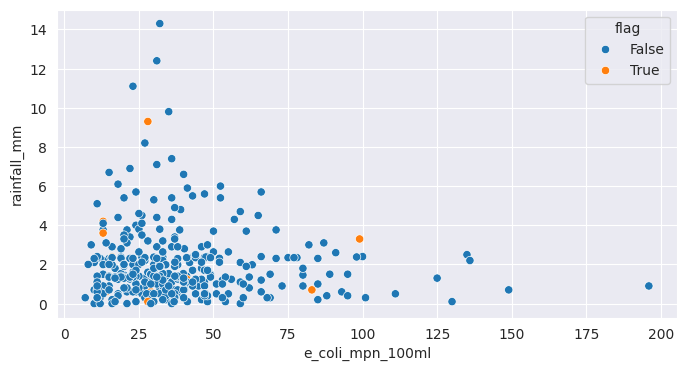

In [39]:
#rainfall vs coliform
plt.figure(figsize=(8,4))
sns.set_style("darkgrid")
sns.scatterplot(x=df_wq["e_coli_mpn_100ml"], y=df_wq["rainfall_mm"], hue=df_wq["flag"])

In [40]:
print(df_lab.head())
print(df_wq.head())


           nitrate_mg_L  phosphate_mg_L  lead_ug_L lab_received     method  \
sample_id                                                                    
S1114          2.357597        0.000000   2.458896   2025-08-29  EPA 300.1   
S1129          1.678005        0.966230   4.159204   2025-08-07  EPA 300.1   
S1188          2.179918        0.670506   9.181004   2025-08-14  EPA 300.1   
S1267          0.818603        0.638103   6.203214   2025-08-02  EPA 300.1   
S1235          0.000000        1.708996   0.000000   2025-08-10  EPA 300.1   

           dil_factor  
sample_id              
S1114               5  
S1129               5  
S1188               1  
S1267               1  
S1235               2  
          station_id           timestamp       temp        pH   DO_mg_L  \
sample_id                                                                 
S1000         ST-001 2025-09-01 10:35:06  25.100000  6.967031  8.065640   
S1001         ST-001 2025-10-20 06:42:00  10.931250  7.19933

In [41]:
#merging data frames
df_merged=df_wq.join(df_lab, how="inner")

In [42]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289 entries, S1001 to S1339
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   station_id         289 non-null    object        
 1   timestamp          289 non-null    datetime64[ns]
 2   temp               289 non-null    float64       
 3   pH                 289 non-null    float64       
 4   DO_mg_L            289 non-null    float64       
 5   turbidity_NTU      289 non-null    float64       
 6   conductivity_uScm  289 non-null    float64       
 7   e_coli_mpn_100ml   289 non-null    float64       
 8   rainfall_mm        289 non-null    float64       
 9   sampler            237 non-null    object        
 10  qc_flag            289 non-null    object        
 11  comments           173 non-null    object        
 12  month              289 non-null    int32         
 13  temp mean          289 non-null    float64       
 14  flag     

In [43]:
#values for each parameter
for i in ["nitrate_mg_L", "phosphate_mg_L", "lead_ug_L"]:
  print(f"mean {i} is {df_merged[i].mean()}")
  print(f"median {i} is {df_merged[i].median()}")
  print("\n")

mean nitrate_mg_L is 1.5311859203504765
median nitrate_mg_L is 1.3039850129479638


mean phosphate_mg_L is 1.1344810539416652
median phosphate_mg_L is 1.041673770856122


mean lead_ug_L is 5.478638445281002
median lead_ug_L is 4.15920368082352




In [44]:
#highest lead values
df_merged["lead_ug_L"].sort_values(ascending=False).head(5)

,lead_ug_L
sample_id,
S1326,29.253558
S1053,24.199188
S1286,22.144746
S1089,22.120235
S1125,19.880967


In [45]:
df_merged["station_id"].unique()

array(['ST-001', 'ST-002', 'ST-003', 'ST-004', 'ST-005', 'ST-006'],
      dtype=object)

<Axes: xlabel='timestamp', ylabel='DO_mg_L'>

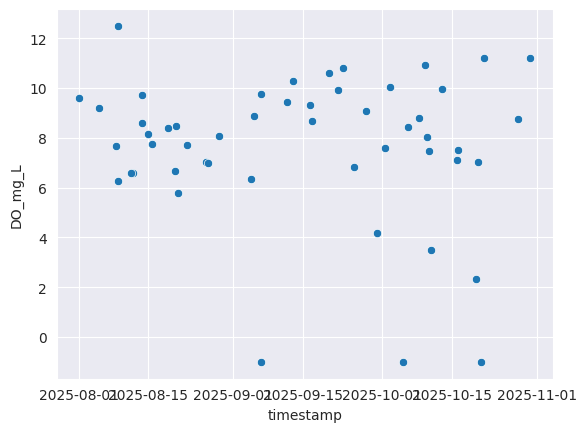

In [46]:
#time vs DO for station 1

sns.scatterplot(x=df_merged[df_merged["station_id"]=="ST-001"]["timestamp"], y=df_merged[df_merged["station_id"]=="ST-001"]["DO_mg_L"])

Text(0.5, 1.0, 'DO')

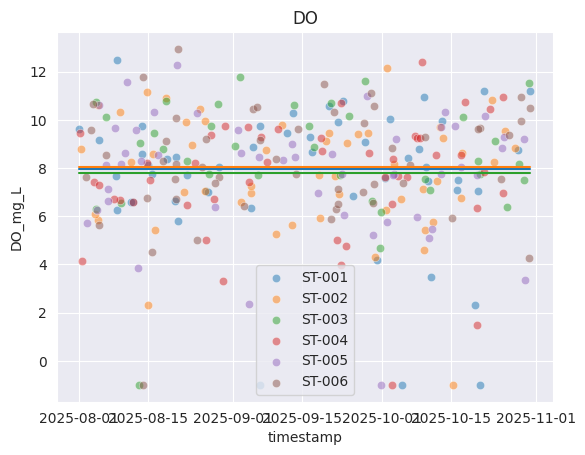

In [47]:
#Plot time-series for one or two parameters (e.g., temperature, DO, nitrate) for each station.

for i in ['ST-001', 'ST-002', 'ST-003', 'ST-004', 'ST-005', 'ST-006']:
    sns.scatterplot(x=df_merged[df_merged["station_id"]==i]["timestamp"], y=df_merged[df_merged["station_id"]==i]["DO_mg_L"],label=i, alpha=0.5)
for i in [0,1,2]:
    sns.lineplot(df_merged, x="timestamp", y=df_merged.groupby("month")["DO_mg_L"].agg("mean").iloc[i])

plt.title("DO")


In [48]:
#calculating z score and detecting outliers
mean_DO=df_merged["DO_mg_L"].mean()
std_DO=df_merged["DO_mg_L"].std()
df_merged["z-score"]=df_merged["DO_mg_L"].apply(lambda x:(x-mean_DO)/std_DO)

In [49]:
#flagging outliers
df_merged["outlier"]=(abs(df_merged["z-score"])>3)
df_merged[df_merged["outlier"]]

,station_id,timestamp,temp,pH,DO_mg_L,turbidity_NTU,conductivity_uScm,e_coli_mpn_100ml,rainfall_mm,sampler,...,temp mean,flag,nitrate_mg_L,phosphate_mg_L,lead_ug_L,lab_received,method,dil_factor,z-score,outlier
sample_id,,,,,,,,,,,,,,,,,,,,,
S1031,ST-001,2025-10-20 19:22:00,17.300,7.983549,-1.0,1.644128,420.759852,13.0,4.200000,pp,...,3.762500,True,1.433772,1.071685,0.000000,2025-09-26,EPA 300.1,10,-3.574395,True
S1032,ST-001,2025-10-05 02:28:00,6.900,7.566837,-1.0,4.131163,314.508494,29.0,0.600000,pp,...,3.762500,True,1.912026,1.587993,2.117765,2025-09-24,EPA 300.1,1,-3.574395,True
S1037,ST-001,2025-09-06 13:35:00,24.700,7.246003,-1.0,8.219930,307.965622,39.0,0.700000,pp,...,1.991667,True,5.960996,0.865633,6.468312,2025-10-23,EPA 300.1,1,-3.574395,True
S1062,ST-002,2025-10-15 09:02:00,28.500,7.551327,-1.0,2.520755,367.282185,14.0,0.600000,NaN,...,1.456250,True,0.000000,0.000000,11.686826,2025-10-09,EPA 300.1,1,-3.574395,True
S1141,ST-003,2025-08-13 01:16:00,7.600,7.042286,-1.0,0.088218,336.476635,41.0,1.254545,ap,...,1.254545,True,2.883369,0.945730,6.133868,2025-09-27,EPA 300.1,2,-3.574395,True
S1174,ST-004,2025-10-03 02:50:36,12.000,7.325093,-1.0,0.037833,388.508467,28.0,9.300000,pp,...,1.983333,True,1.070061,2.032090,0.000000,2025-08-20,EPA 300.1,2,-3.574395,True
S1221,ST-005,2025-09-30 19:24:00,25.400,6.996905,-1.0,1.325777,135.310259,13.0,3.600000,kp,...,2.346154,True,1.534191,1.212661,13.787581,2025-10-03,EPA 300.1,1,-3.574395,True
S1299,ST-006,2025-08-13 23:50:44,21.355,7.481556,-1.0,9.193150,346.120194,28.0,0.100000,pp,...,1.355556,True,2.879790,1.089324,3.517783,2025-03-09,EPA 300.1,10,-3.574395,True


In [50]:
#making the corr matrix
df_heatmap=df_merged[["temp", "DO_mg_L", "turbidity_NTU", "conductivity_uScm", "nitrate_mg_L", "nitrate_mg_L"]].corr()
df_heatmap.rank(ascending=False)

,temp,DO_mg_L,turbidity_NTU,conductivity_uScm,nitrate_mg_L,nitrate_mg_L
temp,1.0,3.0,4.0,5.0,6.0,6.0
DO_mg_L,2.0,1.0,5.0,2.0,3.0,3.0
turbidity_NTU,5.0,6.0,1.0,6.0,4.0,4.0
conductivity_uScm,6.0,2.0,6.0,1.0,5.0,5.0
nitrate_mg_L,3.5,4.5,2.5,3.5,1.5,1.5
nitrate_mg_L,3.5,4.5,2.5,3.5,1.5,1.5


<Axes: >

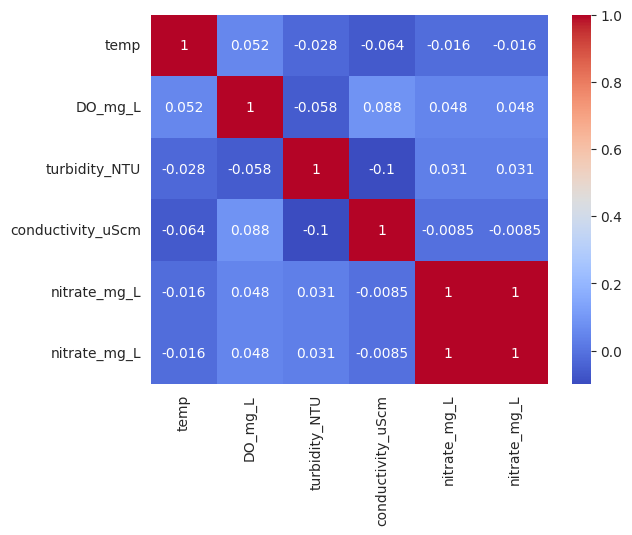

In [51]:
#corr map
sns.heatmap(df_heatmap, cmap="coolwarm", annot=True )

In [52]:
#“Based on data from August–October 2025, which part of the watershed shows the poorest water quality and why?”
df_stations.head()

,station_id,name,lat,lon,river,installed_date,is_active,region,town
0,ST-001,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
1,ST-002,ayer marsh,NaN,-71.588,nashua,2022-06-01,True,central,ayer
2,ST-003,groton bend,42.611,-71.574,nashua,2023-07-15,False,north,groton
3,ST-004,leominster brook,42.525,-71.761,monoosnoc,2020-11-05,False,west,leominster
4,ST-005,fitchburg west,42.581,-71.812,unknown,2019-02-28,True,west,fitchburg


In [53]:
df=df_merged.merge(df_stations, on="station_id", how="inner")

In [54]:
df

,station_id,timestamp,temp,pH,DO_mg_L,turbidity_NTU,conductivity_uScm,e_coli_mpn_100ml,rainfall_mm,sampler,...,z-score,outlier,name,lat,lon,river,installed_date,is_active,region,town
0,ST-001,2025-10-20 06:42:00,10.931250,7.199336,7.046137,0.272843,447.338588,44.000000,0.500000,ap,...,-0.354035,False,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
1,ST-001,2025-08-15 00:08:00,16.588235,7.158432,8.141458,4.016463,323.263983,39.000000,4.800000,pp,...,0.084352,False,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
2,ST-001,2025-08-20 23:55:00,5.800000,7.235330,5.785765,5.551741,319.028805,111.000000,0.500000,dl,...,-0.858482,False,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
3,ST-001,2025-10-10 19:43:00,1.000000,7.115744,3.499331,7.278611,319.663642,21.000000,3.762500,NaN,...,-1.773597,False,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
4,ST-001,2025-09-27 16:58:00,21.400000,6.374462,9.070859,2.412077,457.304036,15.000000,0.900000,NaN,...,0.456333,False,devens river east,42.545,-71.611,nashua,2021-03-15,True,central,devens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,ST-006,2025-10-05 06:07:00,13.300000,7.478494,7.400437,2.613336,315.952241,23.000000,11.100000,dl,...,-0.212232,False,lancaster dam,42.455,-71.681,nashua,2018-09-10,False,west,lancaster
321,ST-006,2025-09-09 17:18:00,11.000000,7.747602,8.380216,1.819812,404.294395,26.000000,2.113333,dl,...,0.179912,False,lancaster dam,42.455,-71.681,nashua,2018-09-10,False,west,lancaster
322,ST-006,2025-08-18 00:45:00,15.900000,8.166685,8.297751,4.991795,293.391822,31.000000,7.100000,dl,...,0.146907,False,lancaster dam,42.455,-71.681,nashua,2018-09-10,False,west,lancaster
323,ST-006,2025-09-05 20:19:00,7.100000,7.113879,10.554896,1.199423,344.433794,37.058824,1.400000,pp,...,1.050299,False,lancaster dam,42.455,-71.681,nashua,2018-09-10,False,west,lancaster


In [55]:
cols = ['temp','pH','DO_mg_L','turbidity_NTU','conductivity_uScm',
        'e_coli_mpn_100ml','rainfall_mm','nitrate_mg_L','phosphate_mg_L',
        'lead_ug_L']

df.groupby("region")[cols].mean()

,temp,pH,DO_mg_L,turbidity_NTU,conductivity_uScm,e_coli_mpn_100ml,rainfall_mm,nitrate_mg_L,phosphate_mg_L,lead_ug_L
region,,,,,,,,,,
central,14.608392,7.386196,7.748554,4.683374,346.125157,39.247479,1.998014,1.688302,1.153680,5.530036
north,14.612290,7.561082,8.503580,5.262997,333.225504,36.456624,1.887316,1.739256,1.148423,5.328712
west,16.437069,7.383289,7.918286,3.564620,346.568031,39.687784,2.033984,1.373363,1.117952,5.479327
